# The breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal components as features.

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

In [71]:
import pandas as pd

# Read stuff
df = pd.read_csv('breast-cancer.data', header=None, 
                 names=['target','age', 'menopause', 'tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad', 'irradiat'])

In [75]:
df['node-caps'] = df['node-caps'].replace('?','no')

In [76]:
from sklearn import preprocessing

# Encode to number
for col in df.columns:
    le = preprocessing.LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])
#     df[col] -= df[col].min()

In [4]:
# Split data and target
df_data = df.drop(['target'], axis=1)
y = df.target

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(123123)

# Split train, test
df_train, df_test, y_train, y_test = train_test_split(df_data, y.values, test_size=0.2)

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(df_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
# Test score
model.score(df_test, y_test)

0.7758620689655172

In [8]:
# F1 score 
from sklearn.metrics import f1_score

f1_score(y_test, model.predict(df_test))

0.38095238095238093

<BarContainer object of 9 artists>

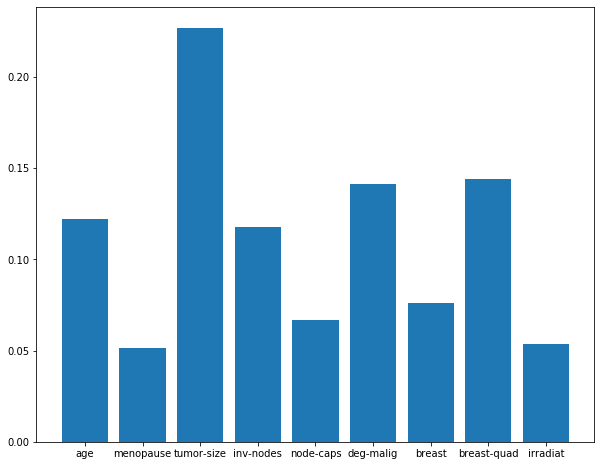

In [24]:
plt.figure(figsize=(10,8))
plt.bar(df_train.columns, model.feature_importances_)

In [26]:
model.feature_importances_, df.columns

(array([0.12222525, 0.05144052, 0.22701127, 0.11779203, 0.06701973,
        0.14152408, 0.07582772, 0.14380064, 0.05335876]),
 Index(['target', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps',
        'deg-malig', 'breast', 'breast-quad', 'irradiat'],
       dtype='object'))

In [27]:
sorted(zip(model.feature_importances_, df_data.columns))

[(0.05144052101705978, 'menopause'),
 (0.05335876285411533, 'irradiat'),
 (0.06701972831495569, 'node-caps'),
 (0.07582771566262014, 'breast'),
 (0.11779202900523383, 'inv-nodes'),
 (0.12222525146589018, 'age'),
 (0.14152408042402692, 'deg-malig'),
 (0.14380063680104352, 'breast-quad'),
 (0.22701127445505473, 'tumor-size')]

In [28]:
[x[1] for x in sorted(zip(model.feature_importances_, df_data.columns), reverse=False)]

['menopause',
 'irradiat',
 'node-caps',
 'breast',
 'inv-nodes',
 'age',
 'deg-malig',
 'breast-quad',
 'tumor-size']

# Quantum dude

In [77]:
# Get most important col
# n columns
col_num = 4
# mvp_col = [x[1] for x in sorted(zip(model.feature_importances_, df_data.columns), reverse=True)[:col_num]]
# Rudy features
mvp_col = ['tumor-size', 'node-caps', 'deg-malig', 'menopause']

In [32]:
mvp_col

['tumor-size', 'breast-quad', 'deg-malig', 'age']

In [91]:
# Get only MVP columns

df_train_q = df_train[mvp_col].values
df_test_q = df_test[mvp_col].values

In [92]:
from qiskit import IBMQ
provider = IBMQ.load_account()

In [149]:
# Choose balance 50 sample
# 25 pos, 25 neg

np.random.seed(777)

pos_sample = 30
neg_sample = 30

pos_label = np.argwhere(y_train == 1).reshape([-1])
chosen_pos_label_idx = pos_label[np.random.permutation(len(pos_label))[:pos_sample]]

neg_label = np.argwhere(y_train == 0).reshape([-1])
chosen_neg_label_idx = neg_label[np.random.permutation(len(neg_label))[:neg_sample]]

# Construct dict to feed QSVM
training_input = {
    0: df_train_q[chosen_neg_label_idx],
    1: df_train_q[chosen_pos_label_idx]
}

test_input = {
    0: df_test_q[y_test == 0],
    1: df_test_q[y_test == 1]
}



In [93]:
def double(x):
    return np.concatenate([x, x], axis=0)

# len(double(df_train_encode[y_train == 0]))

In [94]:
training_input = {
    0: df_train_q[y_train == 0],
    1: double(df_train_q[y_train == 1])
}

test_input = {
    0: df_test_q[y_test == 0],
    1: df_test_q[y_test == 1]
}

In [16]:
training_input[1].shape

(142, 3)

In [95]:
#  Stupid Ordinal input

seed = 10598

vqc_ordinal_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_ordinal_log.append(loss)
    
    
# var_form = TwoLocal(2, ['ry'], 'cx', entanglement='circular', reps=1, insert_barriers=True)
var_form = variational_forms.RYRZ(2, depth=4)

feature_map = ZZFeatureMap(feature_dimension=len(mvp_col), reps=3, entanglement='linear')

qsvm = VQC(SPSA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed,optimization_level=3)


result = qsvm.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
            The <class 'qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  from ipykernel import kernelapp as app
2020-07-09 12:09:40,201:qi

2020-07-09 12:14:17,024:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.7252587
2020-07-09 12:14:17,025:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.7338781
2020-07-09 12:14:23,329:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7102901262138349
2020-07-09 12:14:29,881:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7046572434265648
2020-07-09 12:14:29,882:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 1: 0.7102901
2020-07-09 12:14:29,883:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 1: 0.7046572
2020-07-09 12:14:37,035:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6955810860418654
2020-07-09 12:14:43,406:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7222408561627848
2020-07-09 12:14:43,408:qiskit.aqua.components.optim

2020-07-09 12:17:59,484:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 17: 0.6777103
2020-07-09 12:18:06,320:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6763434357382767
2020-07-09 12:18:12,706:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6790748183543264
2020-07-09 12:18:12,708:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6763434
2020-07-09 12:18:12,709:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 18: 0.6790748
2020-07-09 12:18:19,191:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6789774779245561
2020-07-09 12:18:25,698:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6780386880819181
2020-07-09 12:18:25,700:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 19: 0.6789775
2020-07-09 12:18:25,701:qiskit.aqua.components.o

2020-07-09 12:21:48,858:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6642187798551379
2020-07-09 12:21:55,381:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.654202279903718
2020-07-09 12:21:55,383:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 35: 0.6642188
2020-07-09 12:21:55,383:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.6542023
2020-07-09 12:22:02,292:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6646616714602106
2020-07-09 12:22:08,633:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6534191847183893
2020-07-09 12:22:08,635:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 36: 0.6646617
2020-07-09 12:22:08,636:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: 0.6534192
2020-07-09 12:22:15,089:qiskit.aqua.algorithms.cl

2020-07-09 12:25:38,649:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6416030584695963
2020-07-09 12:25:38,651:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.6457608
2020-07-09 12:25:38,652:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.6416031
2020-07-09 12:25:44,989:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6431820066516291
2020-07-09 12:25:51,332:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6447884939611692
2020-07-09 12:25:51,334:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.6431820
2020-07-09 12:25:51,335:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: 0.6447885
2020-07-09 12:25:57,778:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.642200141305893
2020-07-09 12:26:04,217:qiskit.aqua.algorithms.cl

2020-07-09 12:29:18,454:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 69: 0.6400173
2020-07-09 12:29:18,455:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 69: 0.6435662
2020-07-09 12:29:25,171:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6409679044606037
2020-07-09 12:29:31,453:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6391130673936459
2020-07-09 12:29:31,455:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.6409679
2020-07-09 12:29:31,456:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.6391131
2020-07-09 12:29:38,809:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6377286526122237
2020-07-09 12:29:45,297:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6437776713607952
2020-07-09 12:29:45,299:qiskit.aqua.components.o

2020-07-09 12:33:01,038:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 86: 0.6396835
2020-07-09 12:33:07,391:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6397500955298205
2020-07-09 12:33:13,852:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6398261521865994
2020-07-09 12:33:13,854:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.6397501
2020-07-09 12:33:13,855:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.6398262
2020-07-09 12:33:20,714:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6396837026202244
2020-07-09 12:33:27,172:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.640334238784481
2020-07-09 12:33:27,175:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.6396837
2020-07-09 12:33:27,176:qiskit.aqua.components.op

In [96]:
y_pred = qsvm.predict(df_test_q)[1]


# F1 score
np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-09 12:36:37,095:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.5689655172413793, 0.3902439024390244)

In [101]:
# Save model
# !mkdir models
qsvm.save_model('models/VQC_ordinal_rudy_4_features')

## Encode 3bits to 1qubit
So from $b_1b_2b_3\Rightarrow(\theta,\varphi)\ ; b_i\in\{-1,1\} $

In [78]:
df_q = df[mvp_col]

df_q.head()

,tumor-size,node-caps,deg-malig,menopause
0,5,0,2,2
1,3,0,1,2
2,3,0,1,2
3,2,0,1,0
4,0,0,1,2


In [79]:
df_q = df[mvp_col]

data = []

# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

bit_each_col = []

# Check number of different category in df_all
for col in df_q.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_q[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_q.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data.append(var_list)
    
data = np.array(data)

In [80]:
df_q

,tumor-size,node-caps,deg-malig,menopause
0,5,0,2,2
1,3,0,1,2
2,3,0,1,2
3,2,0,1,0
4,0,0,1,2
5,2,0,1,0
6,4,0,1,2
7,3,0,0,0
8,10,0,1,2
9,3,0,1,2


In [81]:
bit_each_col

[4, 1, 2, 2]

In [82]:
data.shape

(286, 6)

In [83]:
# Show ordinal data vs encoded
df_q.iloc[:5],data[:5]

(   tumor-size  node-caps  deg-malig  menopause
 0           5          0          2          2
 1           3          0          1          2
 2           3          0          1          2
 3           2          0          1          0
 4           0          0          1          2,
 array([[ 2.18627604,  2.35619449,  0.95531662, -0.78539816,  2.18627604,
          2.35619449],
        [ 2.18627604, -0.78539816,  0.95531662, -2.35619449,  0.95531662,
          2.35619449],
        [ 2.18627604, -0.78539816,  0.95531662, -2.35619449,  0.95531662,
          2.35619449],
        [ 2.18627604, -0.78539816,  2.18627604, -2.35619449,  0.95531662,
         -2.35619449],
        [ 2.18627604, -2.35619449,  2.18627604, -2.35619449,  0.95531662,
          2.35619449]]))

In [84]:
# Features for encoding

np.random.seed(123123)

df_train_encode, df_test_encode, y_train, y_test = train_test_split(data, y.values, test_size=0.2)

In [171]:
# Construct dict to feed QSVM

# Choose balance 50 sample

np.random.seed(777)

pos_sample = 60
neg_sample = 60

pos_label = np.argwhere(y_train == 1).reshape([-1])
chosen_pos_label_idx = pos_label[np.random.permutation(len(pos_label))[:pos_sample]]

neg_label = np.argwhere(y_train == 0).reshape([-1])
chosen_neg_label_idx = neg_label[np.random.permutation(len(neg_label))[:neg_sample]]


training_input = {
    0: df_train_encode[chosen_neg_label_idx],
    1: df_train_encode[chosen_pos_label_idx]
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}



In [85]:
training_input = {
    0: df_train_encode[y_train == 0],
    1: double(df_train_encode[y_train == 1])
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


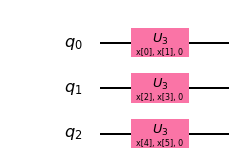

In [86]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2, depth=4)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [87]:
# 

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(SPSA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)


/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-09 11:33:36,140:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-09 11:33:36,144:qiskit.aqua.algorithms.v

2020-07-09 11:37:38,791:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 0: 0.7284473
2020-07-09 11:37:38,792:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 0: 0.7457090
2020-07-09 11:37:44,959:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6999430776566592
2020-07-09 11:37:52,565:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.663335611288653
2020-07-09 11:37:52,568:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 1: 0.6999431
2020-07-09 11:37:52,568:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 1: 0.6633356
2020-07-09 11:37:59,566:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7797554248234284
2020-07-09 11:38:07,618:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8020772582906721
2020-07-09 11:38:07,623:qiskit.aqua.components.optimi

2020-07-09 11:41:16,967:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6151300164268907
2020-07-09 11:41:22,460:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6358248867734133
2020-07-09 11:41:22,463:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 18: 0.6151300
2020-07-09 11:41:22,465:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 18: 0.6358249
2020-07-09 11:41:27,997:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6147638129022999
2020-07-09 11:41:33,505:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6195591231134633
2020-07-09 11:41:33,507:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 19: 0.6147638
2020-07-09 11:41:33,508:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 19: 0.6195591
2020-07-09 11:41:39,038:qiskit.aqua.algorithms.c

2020-07-09 11:45:32,954:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6024558134203376
2020-07-09 11:45:32,956:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 35: 0.6098599
2020-07-09 11:45:32,958:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 35: 0.6024558
2020-07-09 11:45:41,305:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5951698017123594
2020-07-09 11:45:51,922:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6092269931753085
2020-07-09 11:45:51,924:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 36: 0.5951698
2020-07-09 11:45:51,925:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 36: 0.6092270
2020-07-09 11:45:59,407:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5953872787567873
2020-07-09 11:46:06,622:qiskit.aqua.algorithms.c

2020-07-09 11:49:17,143:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 52: 0.5902204
2020-07-09 11:49:17,144:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 52: 0.5886400
2020-07-09 11:49:23,371:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5860824783112702
2020-07-09 11:49:29,891:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5910701146263401
2020-07-09 11:49:29,894:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 53: 0.5860825
2020-07-09 11:49:29,894:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 53: 0.5910701
2020-07-09 11:49:37,348:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5859216193896623
2020-07-09 11:49:43,733:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5881465574414001
2020-07-09 11:49:43,736:qiskit.aqua.components.o

2020-07-09 11:52:54,162:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 69: 0.5854594
2020-07-09 11:53:00,476:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5853732133781349
2020-07-09 11:53:06,726:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5892387101258667
2020-07-09 11:53:06,729:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 70: 0.5853732
2020-07-09 11:53:06,730:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 70: 0.5892387
2020-07-09 11:53:13,408:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5860557644145721
2020-07-09 11:53:20,888:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5800534067599752
2020-07-09 11:53:20,891:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 71: 0.5860558
2020-07-09 11:53:20,892:qiskit.aqua.components.o

2020-07-09 11:56:28,775:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.57559830208877
2020-07-09 11:56:34,349:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5779928398408744
2020-07-09 11:56:34,351:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 87: 0.5755983
2020-07-09 11:56:34,352:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 87: 0.5779928
2020-07-09 11:56:40,079:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5763472357000441
2020-07-09 11:56:47,583:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5772294046286555
2020-07-09 11:56:47,586:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 88: 0.5763472
2020-07-09 11:56:47,587:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 88: 0.5772294
2020-07-09 11:56:54,680:qiskit.aqua.algorithms.cla

In [88]:
# Train acc

y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-09 11:59:10,874:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7324561403508771, 0.5673758865248227)

In [89]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-09 11:59:15,235:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7241379310344828, 0.4666666666666667)

In [90]:
qsvm_encode.save_model('models/VQC_just_encode_v2_model_4_rudy_feature')

# Real machine

In [99]:
training_input = {
    0: df_train_encode[y_train == 0],
    1: double(df_train_encode[y_train == 1])
}

test_input = {
    0: df_test_encode[y_test == 0],
    1: df_test_encode[y_test == 1]
}

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


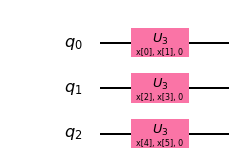

In [100]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data.shape[1])]

var_form = variational_forms.RYRZ(data.shape[1] // 2, depth=4)

qc = QuantumCircuit(data.shape[1] // 2)

for i in range(data.shape[1] // 2):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc #+ tmp1 + tmp2 
feature_map.draw('mpl')

In [ ]:
# 

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(SPSA(100), feature_map, var_form, training_input, callback=loss_history_callback)

provider = IBMQ.get_provider(hub='ibm-q-utokyo', project='qc2020s')
backend = provider.get_backend('ibmq_johannesburg')

# backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)


/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-09 12:56:00,394:qiskit.aqua.quantum_instance:WARNING: The skip Qobj validation does not work for IBMQ provider. Disable it.
2020-07-09 12:56:00,395:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'ibmq_johannesburg (<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='qc2020s')>)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id'], 'coupling_map': [[0, 1], [0, 5], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 

2020-07-09 12:59:26,085:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0695578ba45b001a62960c, status: JobStatus.RUNNING
2020-07-09 12:59:31,785:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0695578ba45b001a62960c, status: JobStatus.RUNNING
2020-07-09 12:59:37,409:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0695578ba45b001a62960c, status: JobStatus.RUNNING
2020-07-09 12:59:43,159:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0695578ba45b001a62960c, status: JobStatus.RUNNING
2020-07-09 12:59:48,818:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0695578ba45b001a62960c, status: JobStatus.RUNNING
2020-07-09 12:59:54,535:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0695578ba45b001a62960c, status: JobStatus.RUNNING
2020-07-09 13:00:00,353:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0695578ba45b001a62960c, status: JobStatus.RUNNING
2020-07-09 13:00:05,911:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f0695578ba45b001a62960c, status: JobStatus.RUNNING
2020-07-09 13:00:14,096:qiskit.a

2020-07-09 13:05:15,632:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06974a8ba45b001a629622, status: JobStatus.RUNNING
2020-07-09 13:05:21,068:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06974a8ba45b001a629622, status: JobStatus.RUNNING
2020-07-09 13:05:26,507:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06974a8ba45b001a629622, status: JobStatus.RUNNING
2020-07-09 13:05:31,885:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06974a8ba45b001a629622, status: JobStatus.RUNNING
2020-07-09 13:05:37,526:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06974a8ba45b001a629622, status: JobStatus.RUNNING
2020-07-09 13:05:43,292:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06974a8ba45b001a629622, status: JobStatus.RUNNING
2020-07-09 13:05:48,959:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06974a8ba45b001a629622, status: JobStatus.RUNNING
2020-07-09 13:05:54,387:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06974a8ba45b001a629622, status: JobStatus.RUNNING
2020-07-09 13:06:00,389:qiskit.a

2020-07-09 13:11:18,675:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069838504d22001939a4b1, status: JobStatus.RUNNING
2020-07-09 13:11:24,325:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069838504d22001939a4b1, status: JobStatus.RUNNING
2020-07-09 13:11:30,025:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069838504d22001939a4b1, status: JobStatus.RUNNING
2020-07-09 13:11:35,395:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069838504d22001939a4b1, status: JobStatus.RUNNING
2020-07-09 13:11:40,996:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069838504d22001939a4b1, status: JobStatus.RUNNING
2020-07-09 13:11:46,636:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069838504d22001939a4b1, status: JobStatus.RUNNING
2020-07-09 13:11:52,232:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069838504d22001939a4b1, status: JobStatus.RUNNING
2020-07-09 13:11:57,994:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069838504d22001939a4b1, status: JobStatus.RUNNING
2020-07-09 13:12:03,621:qiskit.a

2020-07-09 13:17:08,547:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069a1d3ca94d00196385d0, status: JobStatus.RUNNING
2020-07-09 13:17:14,192:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069a1d3ca94d00196385d0, status: JobStatus.RUNNING
2020-07-09 13:17:19,869:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069a1d3ca94d00196385d0, status: JobStatus.RUNNING
2020-07-09 13:17:25,557:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069a1d3ca94d00196385d0, status: JobStatus.RUNNING
2020-07-09 13:17:31,300:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069a1d3ca94d00196385d0, status: JobStatus.RUNNING
2020-07-09 13:17:36,997:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069a1d3ca94d00196385d0, status: JobStatus.RUNNING
2020-07-09 13:17:42,650:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069a1d3ca94d00196385d0, status: JobStatus.RUNNING
2020-07-09 13:17:48,301:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069a1d3ca94d00196385d0, status: JobStatus.RUNNING
2020-07-09 13:17:53,922:qiskit.a

2020-07-09 13:23:11,358:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069b4a504d22001939a4c4, status: JobStatus.RUNNING
2020-07-09 13:23:17,005:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069b4a504d22001939a4c4, status: JobStatus.RUNNING
2020-07-09 13:23:22,725:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069b4a504d22001939a4c4, status: JobStatus.RUNNING
2020-07-09 13:23:28,372:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069b4a504d22001939a4c4, status: JobStatus.RUNNING
2020-07-09 13:23:33,995:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069b4a504d22001939a4c4, status: JobStatus.RUNNING
2020-07-09 13:23:39,621:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069b4a504d22001939a4c4, status: JobStatus.RUNNING
2020-07-09 13:23:45,308:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069b4a504d22001939a4c4, status: JobStatus.RUNNING
2020-07-09 13:23:50,987:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069b4a504d22001939a4c4, status: JobStatus.RUNNING
2020-07-09 13:23:56,727:qiskit.a

2020-07-09 13:29:14,129:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069c3f678d65001bc884e9, status: JobStatus.RUNNING
2020-07-09 13:29:19,804:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069c3f678d65001bc884e9, status: JobStatus.RUNNING
2020-07-09 13:29:25,502:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069c3f678d65001bc884e9, status: JobStatus.RUNNING
2020-07-09 13:29:33,368:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f069c3f678d65001bc884e9
2020-07-09 13:29:33,589:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8102325464896803
2020-07-09 13:29:44,843:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7fa8ede7d550>
2020-07-09 13:29:44,846:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 13:29:44,848:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f069d34504d22001939a4d2']
2020-07-09 13:29:44,850:qiskit.aqua.utils.run_circui

2020-07-09 13:35:10,042:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069e30e463fb001a313149, status: JobStatus.RUNNING
2020-07-09 13:35:15,691:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069e30e463fb001a313149, status: JobStatus.RUNNING
2020-07-09 13:35:21,360:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069e30e463fb001a313149, status: JobStatus.RUNNING
2020-07-09 13:35:27,774:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069e30e463fb001a313149, status: JobStatus.RUNNING
2020-07-09 13:35:33,359:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069e30e463fb001a313149, status: JobStatus.RUNNING
2020-07-09 13:35:38,983:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069e30e463fb001a313149, status: JobStatus.RUNNING
2020-07-09 13:35:44,616:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069e30e463fb001a313149, status: JobStatus.RUNNING
2020-07-09 13:35:50,268:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069e30e463fb001a313149, status: JobStatus.RUNNING
2020-07-09 13:35:55,893:qiskit.a

2020-07-09 13:41:10,865:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069f1e89280b001b1bc787, status: JobStatus.RUNNING
2020-07-09 13:41:16,499:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069f1e89280b001b1bc787, status: JobStatus.RUNNING
2020-07-09 13:41:22,228:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069f1e89280b001b1bc787, status: JobStatus.RUNNING
2020-07-09 13:41:27,839:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069f1e89280b001b1bc787, status: JobStatus.RUNNING
2020-07-09 13:41:33,472:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069f1e89280b001b1bc787, status: JobStatus.RUNNING
2020-07-09 13:41:39,144:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f069f1e89280b001b1bc787, status: JobStatus.RUNNING
2020-07-09 13:41:47,175:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f069f1e89280b001b1bc787
2020-07-09 13:41:47,298:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7926197283705255
2020-07-09 13:41:57,523:qiskit.aqua.utils

2020-07-09 13:47:02,233:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1057c6503001b07e68d, status: JobStatus.RUNNING
2020-07-09 13:47:07,825:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1057c6503001b07e68d, status: JobStatus.RUNNING
2020-07-09 13:47:13,482:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1057c6503001b07e68d, status: JobStatus.RUNNING
2020-07-09 13:47:19,109:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1057c6503001b07e68d, status: JobStatus.RUNNING
2020-07-09 13:47:24,725:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1057c6503001b07e68d, status: JobStatus.RUNNING
2020-07-09 13:47:30,364:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1057c6503001b07e68d, status: JobStatus.RUNNING
2020-07-09 13:47:35,976:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1057c6503001b07e68d, status: JobStatus.RUNNING
2020-07-09 13:47:41,329:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1057c6503001b07e68d, status: JobStatus.RUNNING
2020-07-09 13:47:46,930:qiskit.a

2020-07-09 13:53:04,309:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1fd504d22001939a4f7, status: JobStatus.RUNNING
2020-07-09 13:53:09,703:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1fd504d22001939a4f7, status: JobStatus.RUNNING
2020-07-09 13:53:15,358:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1fd504d22001939a4f7, status: JobStatus.RUNNING
2020-07-09 13:53:21,030:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1fd504d22001939a4f7, status: JobStatus.RUNNING
2020-07-09 13:53:26,685:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1fd504d22001939a4f7, status: JobStatus.RUNNING
2020-07-09 13:53:32,309:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1fd504d22001939a4f7, status: JobStatus.RUNNING
2020-07-09 13:53:37,935:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1fd504d22001939a4f7, status: JobStatus.RUNNING
2020-07-09 13:53:43,563:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a1fd504d22001939a4f7, status: JobStatus.RUNNING
2020-07-09 13:53:49,263:qiskit.a

2020-07-09 13:58:48,167:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a3e842ca3f001b4c0e55, status: JobStatus.RUNNING
2020-07-09 13:58:53,804:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a3e842ca3f001b4c0e55, status: JobStatus.RUNNING
2020-07-09 13:58:59,446:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a3e842ca3f001b4c0e55, status: JobStatus.RUNNING
2020-07-09 13:59:05,166:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a3e842ca3f001b4c0e55, status: JobStatus.RUNNING
2020-07-09 13:59:10,770:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a3e842ca3f001b4c0e55, status: JobStatus.RUNNING
2020-07-09 13:59:16,486:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a3e842ca3f001b4c0e55, status: JobStatus.RUNNING
2020-07-09 13:59:22,106:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a3e842ca3f001b4c0e55, status: JobStatus.RUNNING
2020-07-09 13:59:27,478:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a3e842ca3f001b4c0e55, status: JobStatus.RUNNING
2020-07-09 13:59:33,151:qiskit.a

2020-07-09 14:04:47,950:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a4d8678d65001bc88537, status: JobStatus.RUNNING
2020-07-09 14:04:53,561:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a4d8678d65001bc88537, status: JobStatus.RUNNING
2020-07-09 14:04:58,921:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a4d8678d65001bc88537, status: JobStatus.RUNNING
2020-07-09 14:05:04,531:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a4d8678d65001bc88537, status: JobStatus.RUNNING
2020-07-09 14:05:10,195:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a4d8678d65001bc88537, status: JobStatus.RUNNING
2020-07-09 14:05:15,872:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a4d8678d65001bc88537, status: JobStatus.RUNNING
2020-07-09 14:05:21,558:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a4d8678d65001bc88537, status: JobStatus.RUNNING
2020-07-09 14:05:26,952:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a4d8678d65001bc88537, status: JobStatus.RUNNING
2020-07-09 14:05:32,575:qiskit.a

2020-07-09 14:10:33,909:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a6b442ca3f001b4c0e6f, status: JobStatus.RUNNING
2020-07-09 14:10:39,541:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a6b442ca3f001b4c0e6f, status: JobStatus.RUNNING
2020-07-09 14:10:45,277:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a6b442ca3f001b4c0e6f, status: JobStatus.RUNNING
2020-07-09 14:10:50,926:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a6b442ca3f001b4c0e6f, status: JobStatus.RUNNING
2020-07-09 14:10:56,544:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a6b442ca3f001b4c0e6f, status: JobStatus.RUNNING
2020-07-09 14:11:02,148:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a6b442ca3f001b4c0e6f, status: JobStatus.RUNNING
2020-07-09 14:11:07,510:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a6b442ca3f001b4c0e6f, status: JobStatus.RUNNING
2020-07-09 14:11:13,136:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a6b442ca3f001b4c0e6f, status: JobStatus.RUNNING
2020-07-09 14:11:18,801:qiskit.a

2020-07-09 14:16:37,696:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a7a3bf5dc0001a17c893, status: JobStatus.RUNNING
2020-07-09 14:16:43,325:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a7a3bf5dc0001a17c893, status: JobStatus.RUNNING
2020-07-09 14:16:48,999:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a7a3bf5dc0001a17c893, status: JobStatus.RUNNING
2020-07-09 14:16:54,638:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a7a3bf5dc0001a17c893, status: JobStatus.RUNNING
2020-07-09 14:17:00,259:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a7a3bf5dc0001a17c893, status: JobStatus.RUNNING
2020-07-09 14:17:05,583:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a7a3bf5dc0001a17c893, status: JobStatus.RUNNING
2020-07-09 14:17:11,324:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a7a3bf5dc0001a17c893, status: JobStatus.RUNNING
2020-07-09 14:17:17,052:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a7a3bf5dc0001a17c893, status: JobStatus.RUNNING
2020-07-09 14:17:22,691:qiskit.a

2020-07-09 14:22:41,660:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a898af9edf001b9aed61, status: JobStatus.RUNNING
2020-07-09 14:22:47,327:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a898af9edf001b9aed61, status: JobStatus.RUNNING
2020-07-09 14:22:52,987:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a898af9edf001b9aed61, status: JobStatus.RUNNING
2020-07-09 14:22:58,757:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a898af9edf001b9aed61, status: JobStatus.RUNNING
2020-07-09 14:23:04,442:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a898af9edf001b9aed61, status: JobStatus.RUNNING
2020-07-09 14:23:10,228:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a898af9edf001b9aed61, status: JobStatus.RUNNING
2020-07-09 14:23:15,859:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a898af9edf001b9aed61, status: JobStatus.RUNNING
2020-07-09 14:23:21,624:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06a898af9edf001b9aed61, status: JobStatus.RUNNING
2020-07-09 14:23:27,258:qiskit.a

2020-07-09 14:28:34,530:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aad0678d65001bc8856e, status: JobStatus.RUNNING
2020-07-09 14:28:40,228:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aad0678d65001bc8856e, status: JobStatus.RUNNING
2020-07-09 14:28:46,014:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aad0678d65001bc8856e, status: JobStatus.RUNNING
2020-07-09 14:28:51,655:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aad0678d65001bc8856e, status: JobStatus.RUNNING
2020-07-09 14:28:57,342:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aad0678d65001bc8856e, status: JobStatus.RUNNING
2020-07-09 14:29:03,029:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aad0678d65001bc8856e, status: JobStatus.RUNNING
2020-07-09 14:29:08,639:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aad0678d65001bc8856e, status: JobStatus.RUNNING
2020-07-09 14:29:14,468:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aad0678d65001bc8856e, status: JobStatus.RUNNING
2020-07-09 14:29:20,163:qiskit.a

2020-07-09 14:34:37,359:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06abc47c6503001b07e6ed, status: JobStatus.RUNNING
2020-07-09 14:34:42,986:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06abc47c6503001b07e6ed, status: JobStatus.RUNNING
2020-07-09 14:34:48,811:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06abc47c6503001b07e6ed, status: JobStatus.RUNNING
2020-07-09 14:34:54,407:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06abc47c6503001b07e6ed, status: JobStatus.RUNNING
2020-07-09 14:35:00,178:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06abc47c6503001b07e6ed, status: JobStatus.RUNNING
2020-07-09 14:35:05,823:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06abc47c6503001b07e6ed, status: JobStatus.RUNNING
2020-07-09 14:35:11,649:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06abc47c6503001b07e6ed, status: JobStatus.RUNNING
2020-07-09 14:35:17,489:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06abc47c6503001b07e6ed, status: JobStatus.RUNNING
2020-07-09 14:35:23,326:qiskit.a

2020-07-09 14:40:30,928:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06adb03ca94d0019638672, status: JobStatus.RUNNING
2020-07-09 14:40:36,457:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06adb03ca94d0019638672, status: JobStatus.RUNNING
2020-07-09 14:40:42,027:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06adb03ca94d0019638672, status: JobStatus.RUNNING
2020-07-09 14:40:47,665:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06adb03ca94d0019638672, status: JobStatus.RUNNING
2020-07-09 14:40:53,353:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06adb03ca94d0019638672, status: JobStatus.RUNNING
2020-07-09 14:40:58,992:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06adb03ca94d0019638672, status: JobStatus.RUNNING
2020-07-09 14:41:04,686:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06adb03ca94d0019638672, status: JobStatus.RUNNING
2020-07-09 14:41:10,557:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06adb03ca94d0019638672, status: JobStatus.RUNNING
2020-07-09 14:41:16,291:qiskit.a

2020-07-09 14:46:37,412:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aea9af9edf001b9aeda5, status: JobStatus.RUNNING
2020-07-09 14:46:43,039:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aea9af9edf001b9aeda5, status: JobStatus.RUNNING
2020-07-09 14:46:48,693:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aea9af9edf001b9aeda5, status: JobStatus.RUNNING
2020-07-09 14:46:54,419:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aea9af9edf001b9aeda5, status: JobStatus.RUNNING
2020-07-09 14:47:00,041:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aea9af9edf001b9aeda5, status: JobStatus.RUNNING
2020-07-09 14:47:05,782:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aea9af9edf001b9aeda5, status: JobStatus.RUNNING
2020-07-09 14:47:11,522:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aea9af9edf001b9aeda5, status: JobStatus.RUNNING
2020-07-09 14:47:17,245:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06aea9af9edf001b9aeda5, status: JobStatus.RUNNING
2020-07-09 14:47:22,870:qiskit.a

2020-07-09 14:52:24,629:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b09389280b001b1bc81f, status: JobStatus.VALIDATING
2020-07-09 14:52:30,240:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b09389280b001b1bc81f, status: JobStatus.VALIDATING
2020-07-09 14:52:35,912:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b09389280b001b1bc81f, status: JobStatus.RUNNING
2020-07-09 14:52:41,563:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b09389280b001b1bc81f, status: JobStatus.RUNNING
2020-07-09 14:52:47,186:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b09389280b001b1bc81f, status: JobStatus.RUNNING
2020-07-09 14:52:52,927:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b09389280b001b1bc81f, status: JobStatus.RUNNING
2020-07-09 14:52:58,559:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b09389280b001b1bc81f, status: JobStatus.RUNNING
2020-07-09 14:53:04,239:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b09389280b001b1bc81f, status: JobStatus.RUNNING
2020-07-09 14:53:09,875:qi

2020-07-09 14:58:28,670:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b18f8ba45b001a6296f8, status: JobStatus.RUNNING
2020-07-09 14:58:34,013:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b18f8ba45b001a6296f8, status: JobStatus.RUNNING
2020-07-09 14:58:39,668:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b18f8ba45b001a6296f8, status: JobStatus.RUNNING
2020-07-09 14:58:45,301:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b18f8ba45b001a6296f8, status: JobStatus.RUNNING
2020-07-09 14:58:50,895:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b18f8ba45b001a6296f8, status: JobStatus.RUNNING
2020-07-09 14:58:56,558:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b18f8ba45b001a6296f8, status: JobStatus.RUNNING
2020-07-09 14:59:02,231:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b18f8ba45b001a6296f8, status: JobStatus.RUNNING
2020-07-09 14:59:07,875:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b18f8ba45b001a6296f8, status: JobStatus.RUNNING
2020-07-09 14:59:13,507:qiskit.a

2020-07-09 15:04:29,786:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b2877c6503001b07e725, status: JobStatus.RUNNING
2020-07-09 15:04:35,384:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b2877c6503001b07e725, status: JobStatus.RUNNING
2020-07-09 15:04:43,014:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f06b2877c6503001b07e725
2020-07-09 15:04:43,134:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.787462058385136
2020-07-09 15:04:53,008:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7fa8eca34e48>
2020-07-09 15:04:53,011:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 15:04:53,012:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06b380678d65001bc885c6']
2020-07-09 15:04:53,014:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f06b380678d65001bc885c6
2020-07-09 15:04:53,590:qiskit.aqua.utils.run_circuits:INFO: 

2020-07-09 15:10:22,914:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b474af9edf001b9aedfa, status: JobStatus.RUNNING
2020-07-09 15:10:28,528:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b474af9edf001b9aedfa, status: JobStatus.RUNNING
2020-07-09 15:10:34,177:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b474af9edf001b9aedfa, status: JobStatus.RUNNING
2020-07-09 15:10:39,494:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b474af9edf001b9aedfa, status: JobStatus.RUNNING
2020-07-09 15:10:45,131:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b474af9edf001b9aedfa, status: JobStatus.RUNNING
2020-07-09 15:10:50,767:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b474af9edf001b9aedfa, status: JobStatus.RUNNING
2020-07-09 15:10:56,171:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b474af9edf001b9aedfa, status: JobStatus.RUNNING
2020-07-09 15:11:01,821:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b474af9edf001b9aedfa, status: JobStatus.RUNNING
2020-07-09 15:11:07,555:qiskit.a

2020-07-09 15:16:26,560:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b56e678d65001bc885fb, status: JobStatus.RUNNING
2020-07-09 15:16:32,234:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b56e678d65001bc885fb, status: JobStatus.RUNNING
2020-07-09 15:16:37,967:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b56e678d65001bc885fb, status: JobStatus.RUNNING
2020-07-09 15:16:43,632:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b56e678d65001bc885fb, status: JobStatus.RUNNING
2020-07-09 15:16:49,300:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b56e678d65001bc885fb, status: JobStatus.RUNNING
2020-07-09 15:16:54,928:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b56e678d65001bc885fb, status: JobStatus.RUNNING
2020-07-09 15:17:02,925:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f06b56e678d65001bc885fb
2020-07-09 15:17:03,081:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.8125003632189718
2020-07-09 15:17:18,277:qiskit.aqua.utils

2020-07-09 15:22:36,935:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 15:22:36,938:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06b7a4504d22001939a5f3']
2020-07-09 15:22:36,940:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f06b7a4504d22001939a5f3
2020-07-09 15:22:37,486:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b7a4504d22001939a5f3, status: JobStatus.VALIDATING
2020-07-09 15:22:43,049:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b7a4504d22001939a5f3, status: JobStatus.VALIDATING
2020-07-09 15:22:48,649:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b7a4504d22001939a5f3, status: JobStatus.RUNNING
2020-07-09 15:22:53,974:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b7a4504d22001939a5f3, status: JobStatus.RUNNING
2020-07-09 15:22:59,620:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b7a4504d22001939a5f3, status: JobStatus.RUNNING
2020-07-09 15:23:05,559:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b7a4504

2020-07-09 15:28:30,967:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b8a13ca94d0019638722, status: JobStatus.RUNNING
2020-07-09 15:28:36,602:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b8a13ca94d0019638722, status: JobStatus.RUNNING
2020-07-09 15:28:42,277:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b8a13ca94d0019638722, status: JobStatus.RUNNING
2020-07-09 15:28:47,916:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b8a13ca94d0019638722, status: JobStatus.RUNNING
2020-07-09 15:28:53,612:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b8a13ca94d0019638722, status: JobStatus.RUNNING
2020-07-09 15:28:59,247:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b8a13ca94d0019638722, status: JobStatus.RUNNING
2020-07-09 15:29:04,852:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b8a13ca94d0019638722, status: JobStatus.RUNNING
2020-07-09 15:29:10,467:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b8a13ca94d0019638722, status: JobStatus.RUNNING
2020-07-09 15:29:16,060:qiskit.a

2020-07-09 15:34:36,386:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b998504d22001939a602, status: JobStatus.RUNNING
2020-07-09 15:34:42,048:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06b998504d22001939a602, status: JobStatus.RUNNING
2020-07-09 15:34:49,598:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f06b998504d22001939a602
2020-07-09 15:34:49,825:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7973502533376976
2020-07-09 15:35:08,950:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7fa8ecc170b8>
2020-07-09 15:35:08,952:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 15:35:08,954:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06ba948ba45b001a62978f']
2020-07-09 15:35:08,957:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f06ba948ba45b001a62978f
2020-07-09 15:35:09,502:qiskit.aqua.utils.run_circuits:INFO:

2020-07-09 15:40:35,705:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bb8b7c6503001b07e7b0, status: JobStatus.RUNNING
2020-07-09 15:40:41,350:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bb8b7c6503001b07e7b0, status: JobStatus.RUNNING
2020-07-09 15:40:46,965:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bb8b7c6503001b07e7b0, status: JobStatus.RUNNING
2020-07-09 15:40:52,546:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bb8b7c6503001b07e7b0, status: JobStatus.RUNNING
2020-07-09 15:40:58,210:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bb8b7c6503001b07e7b0, status: JobStatus.RUNNING
2020-07-09 15:41:03,862:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bb8b7c6503001b07e7b0, status: JobStatus.RUNNING
2020-07-09 15:41:09,495:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bb8b7c6503001b07e7b0, status: JobStatus.RUNNING
2020-07-09 15:41:15,109:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bb8b7c6503001b07e7b0, status: JobStatus.RUNNING
2020-07-09 15:41:20,715:qiskit.a

2020-07-09 15:46:35,177:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bc85af9edf001b9aee7f, status: JobStatus.RUNNING
2020-07-09 15:46:40,519:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bc85af9edf001b9aee7f, status: JobStatus.RUNNING
2020-07-09 15:46:46,188:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bc85af9edf001b9aee7f, status: JobStatus.RUNNING
2020-07-09 15:46:51,512:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bc85af9edf001b9aee7f, status: JobStatus.RUNNING
2020-07-09 15:46:57,181:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bc85af9edf001b9aee7f, status: JobStatus.RUNNING
2020-07-09 15:47:02,821:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bc85af9edf001b9aee7f, status: JobStatus.RUNNING
2020-07-09 15:47:08,478:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bc85af9edf001b9aee7f, status: JobStatus.RUNNING
2020-07-09 15:47:16,647:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f06bc85af9edf001b9aee7f
2020-07-09 15:47:17,122:qiskit.aqu

2020-07-09 15:52:19,036:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06be75af9edf001b9aee8f, status: JobStatus.RUNNING
2020-07-09 15:52:24,659:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06be75af9edf001b9aee8f, status: JobStatus.RUNNING
2020-07-09 15:52:30,326:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06be75af9edf001b9aee8f, status: JobStatus.RUNNING
2020-07-09 15:52:35,908:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06be75af9edf001b9aee8f, status: JobStatus.RUNNING
2020-07-09 15:52:41,559:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06be75af9edf001b9aee8f, status: JobStatus.RUNNING
2020-07-09 15:52:47,161:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06be75af9edf001b9aee8f, status: JobStatus.RUNNING
2020-07-09 15:52:52,811:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06be75af9edf001b9aee8f, status: JobStatus.RUNNING
2020-07-09 15:52:58,148:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06be75af9edf001b9aee8f, status: JobStatus.RUNNING
2020-07-09 15:53:03,754:qiskit.a

2020-07-09 15:58:27,535:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bf728ba45b001a6297b4, status: JobStatus.RUNNING
2020-07-09 15:58:33,159:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bf728ba45b001a6297b4, status: JobStatus.RUNNING
2020-07-09 15:58:38,769:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bf728ba45b001a6297b4, status: JobStatus.RUNNING
2020-07-09 15:58:44,083:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bf728ba45b001a6297b4, status: JobStatus.RUNNING
2020-07-09 15:58:49,678:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bf728ba45b001a6297b4, status: JobStatus.RUNNING
2020-07-09 15:58:55,341:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bf728ba45b001a6297b4, status: JobStatus.RUNNING
2020-07-09 15:59:00,667:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bf728ba45b001a6297b4, status: JobStatus.RUNNING
2020-07-09 15:59:06,271:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06bf728ba45b001a6297b4, status: JobStatus.RUNNING
2020-07-09 15:59:11,919:qiskit.a

2020-07-09 16:04:14,083:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06c167504d22001939a63e']
2020-07-09 16:04:14,088:qiskit.aqua.utils.run_circuits:INFO: Running 0-th qobj, job id: 5f06c167504d22001939a63e
2020-07-09 16:04:14,632:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c167504d22001939a63e, status: JobStatus.VALIDATING
2020-07-09 16:04:20,221:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c167504d22001939a63e, status: JobStatus.VALIDATING
2020-07-09 16:04:25,568:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c167504d22001939a63e, status: JobStatus.RUNNING
2020-07-09 16:04:31,184:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c167504d22001939a63e, status: JobStatus.RUNNING
2020-07-09 16:04:36,857:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c167504d22001939a63e, status: JobStatus.RUNNING
2020-07-09 16:04:42,476:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c167504d22001939a63e, status: JobStatus.RUNNING
2020-07-09 16:04:48,089:qiskit.aqua.utils.run_circui

2020-07-09 16:10:03,337:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c25e504d22001939a649, status: JobStatus.RUNNING
2020-07-09 16:10:09,046:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c25e504d22001939a649, status: JobStatus.RUNNING
2020-07-09 16:10:14,731:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c25e504d22001939a649, status: JobStatus.RUNNING
2020-07-09 16:10:20,388:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c25e504d22001939a649, status: JobStatus.RUNNING
2020-07-09 16:10:26,233:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c25e504d22001939a649, status: JobStatus.RUNNING
2020-07-09 16:10:31,867:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c25e504d22001939a649, status: JobStatus.RUNNING
2020-07-09 16:10:37,500:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c25e504d22001939a649, status: JobStatus.RUNNING
2020-07-09 16:10:43,158:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c25e504d22001939a649, status: JobStatus.RUNNING
2020-07-09 16:10:48,805:qiskit.a

2020-07-09 16:16:06,757:qiskit.aqua.utils.run_circuits:INFO: Job id: 5f06c34faf9edf001b9aeec0, status: JobStatus.RUNNING
2020-07-09 16:16:14,562:qiskit.aqua.utils.run_circuits:INFO: COMPLETED the 0-th qobj, job id: 5f06c34faf9edf001b9aeec0
2020-07-09 16:16:14,681:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6771089290508309
2020-07-09 16:16:14,683:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 3: 0.6741369
2020-07-09 16:16:14,684:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 3: 0.6771089
2020-07-09 16:16:27,464:qiskit.aqua.utils.run_circuits:INFO: Backend status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x7fa8ec2c2dd8>
2020-07-09 16:16:27,468:qiskit.aqua.utils.run_circuits:INFO: There are 1 jobs are submitted.
2020-07-09 16:16:27,469:qiskit.aqua.utils.run_circuits:INFO: All job ids:
['5f06c444504d22001939a656']
2020-07-09 16:16:27,471:qiskit.aqua.utils.run_ci

In [88]:
# Train acc

y_pred = qsvm_encode.predict(df_train_encode)[1]

np.mean(y_pred == y_train), f1_score(y_train, y_pred)

2020-07-09 11:59:10,874:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7324561403508771, 0.5673758865248227)

In [89]:
# Test acc

y_pred = qsvm_encode.predict(df_test_encode)[1]

np.mean(y_pred == y_test), f1_score(y_test, y_pred)

2020-07-09 11:59:15,235:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7241379310344828, 0.4666666666666667)

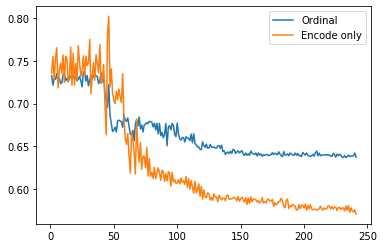

In [98]:
# Get some plot
# Training loss
x_plot = np.arange(1, 242)

plt.plot(x_plot, vqc_ordinal_log, label='Ordinal')
plt.plot(x_plot, vqc_encode_only_log, label='Encode only')
# plt.plot(x_plot, vqc_encode_zz_log, label='Encode+ZZ')
plt.legend()

In [58]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright